### **Paso 1: Unificación y Detección de Duplicados**
**Objetivo**: Combinar los 5 archivos CSV en un único DataFrame y verificar si hay duplicados entre los listings.

#### **Acciones a realizar**:
1. **Cargar los archivos CSV**:

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
from pathlib import Path

# Configurar pandas para mostrar todas las salidas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.max_rows', None)     # Mostrar todas las filas
pd.set_option('display.width', 1000)        # Ancho máximo del display
pd.set_option('display.max_colwidth', None) # Mostrar contenido completo de columnas

raw_data_dir = Path("../data/raw/inside/")
processed_data_dir = Path("../data/processed/")
files = [
    raw_data_dir / "listings-03-2024.csv",
    raw_data_dir / "listings-03-2025.csv",
    raw_data_dir / "listings-06-2024.csv",
    raw_data_dir / "listings-12-2024.csv",
]

# Leer y concatenar archivos
print("="*80)
print("1. READING AND CONCATENATING ALL FILES...")
dfs = [pd.read_csv(file) for file in files]
df = pd.concat(dfs, ignore_index=True)
print("✓ Files combined successfully")
print("="*80)


# Función para mostrar secciones claramente
def show_section(title, content, max_lines=20):
    print("\n" + "="*80)
    print(f"{title.upper()}")
    print("="*80)
    if isinstance(content, (pd.DataFrame, pd.Series)):
        with pd.option_context('display.max_rows', max_lines):
            print(content)
    else:
        print(content)

# Mostrar información básica
show_section("3. BASIC DATAFRAME INFORMATION", df.info())

# Mostrar filas
show_section("4. FIRST 5 ROWS", df.head())
show_section("5. LAST 5 ROWS", df.tail())

# Estadísticas
show_section("6. DESCRIPTIVE STATISTICS", df.describe(include='all'))

# Uso de memoria
show_section("7. MEMORY USAGE", df.memory_usage(deep=True))

# Tipos de datos
show_section("8. DATA TYPES", df.dtypes)

# Columnas y forma
show_section("9. COLUMN NAMES", df.columns.tolist())
show_section("10. DATAFRAME SHAPE", f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Valores únicos
show_section("11. UNIQUE VALUES COUNT PER COLUMN", df.nunique())

# Valores nulos
show_section("12. NULL VALUES COUNT PER COLUMN", df.isnull().sum())

# Duplicados
show_section("13. DUPLICATED ROWS COUNT", df.duplicated().sum())

# Valores únicos por columna (detallado)
show_section("14. DETAILED UNIQUE VALUES PER COLUMN", "\n".join([f"{col}: {df[col].nunique()}" for col in df.columns]))

# Valores únicos por fila (primeras 5)
show_section("15. UNIQUE VALUES PER ROW (FIRST 5 ROWS)", "\n".join([f"Row {i}: {df.iloc[i].nunique()}" for i in range(min(5, df.shape[0]))]))

print("\n" + "="*80)
print("✓ ALL DATA HAS BEEN DISPLAYED")
print("="*80)

1. READING AND CONCATENATING ALL FILES...
✓ Files combined successfully
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104996 entries, 0 to 104995
Data columns (total 79 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            104996 non-null  int64  
 1   listing_url                                   104996 non-null  object 
 2   scrape_id                                     104996 non-null  int64  
 3   last_scraped                                  104996 non-null  object 
 4   source                                        104996 non-null  object 
 5   name                                          104996 non-null  object 
 6   description                                   101152 non-null  object 
 7   neighborhood_overview                         49800 non-null   object 
 8   picture_url                                   104991

2. **Verificar duplicados**:
   - Usaremos `id` (identificador único de Airbnb) y `scrape_id` (fecha de scraping) para detectar si un mismo listing aparece en múltiples archivos.

In [2]:
# Verificar duplicados basados en 'id' y 'scrape_id'
duplicates = df.duplicated(subset=['id', 'scrape_id'], keep=False)
print(f"Número de filas duplicadas: {duplicates.sum()}")

Número de filas duplicadas: 0


3. **Eliminar duplicados** (si los hay):

In [3]:
df = df.drop_duplicates(subset=['id', 'scrape_id'], keep='last')

4. **Guardar el DataFrame unificado** (opcional, para no repetir el proceso):

In [4]:
# Guardar a CSV
print("\n2. SAVING COMBINED DATA TO CSV...")
df.to_csv(raw_data_dir / "raw_combined_listings.csv", index=False)
print(f"✓ Saved to {raw_data_dir / 'raw_combined_listings.csv'}")
print("="*80)


2. SAVING COMBINED DATA TO CSV...
✓ Saved to ../data/raw/inside/raw_combined_listings.csv


#### **Qué esperamos analizar**:
- ¿Hay listings que aparecen en múltiples archivos? (ej. si un mismo `id` tiene diferentes `scrape_id`).
- ¿Los duplicados son exactos o hay diferencias en columnas como `price`, `number_of_reviews`, etc.?

---

### **Siguiente paso (una vez me compartas los resultados)**:
- Análisis de valores nulos y columnas irrelevantes (eliminaremos las que no aporten al modelo de predicción de precios).
- Estadísticas descriptivas básicas de las columnas numéricas (como `price`, `bedrooms`, etc.).

--- 

**Por favor, comparte**: 
1. El número total de filas después de unificar los archivos.
2. El número de duplicados encontrados (si hubo).
3. ¿Alguna observación interesante? (ej. ¿los duplicados tienen precios diferentes?).

Así ajustamos el siguiente paso basado en estos resultados. ¡Vamos poco a poco!

### **Análisis de los Resultados y Siguiente Paso**

#### **Observaciones Clave:**
1. **Datos Unificados Correctamente**:  
   - Se han combinado **104,996 registros** de los 5 archivos CSV sin duplicados exactos (`duplicates.sum() = 0`).  
   - No hay filas duplicadas (mismo `id` y `scrape_id`), pero hay listings con el mismo `id` en diferentes archivos (ej: actualizaciones temporales).  
--- 

2. **Problemas Detectados**:  
   - **Columnas con Alta Cardinalidad**:  
     - `amenities` (90,997 valores únicos), `description` (38,189 únicos), `name` (38,541 únicos). Difícil de usar directamente como predictor.  
     - `price` está como texto (ej: `"$31.00"`) y tiene valores nulos (8,2397 no nulos).  
   - **Valores Nulos Relevantes**:  
     - `price` (21.5% nulos), `bathrooms` (21.5% nulos), `bedrooms` (9.3% nulos), `beds` (21.6% nulos).  
     - Variables clave como `review_scores_rating` (20.8% nulos) y `host_response_rate` (19.7% nulos).  

     3. **Columnas con Baja Utilidad**:  
   - URLs (`listing_url`, `picture_url`), IDs (`id`, `scrape_id`), columnas temporales (`last_scraped`, `host_since`).  
   - Columnas redundantes: `host_listings_count` vs `calculated_host_listings_count`.  

### **Siguiente Paso: Limpieza Inicial y Preparación de Variables**  
**Objetivo**: Preparar el dataset para el EDA enfocándonos en predictores relevantes para el precio. 

#### **Acciones Propuestas**:  
1. **Eliminar Columnas No Relevantess**:  

In [5]:
columns_to_drop = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'host_url',
    'host_thumbnail_url', 'host_picture_url', 'calendar_updated',
    'license', 'calendar_last_scraped', 'neighbourhood'  # Redundante con neighbourhood_cleansed
]
df_clean = df.drop(columns=columns_to_drop)


2. **Convertir `price` a Numérico**: 

In [6]:
df_clean['price'] = df_clean['price'].str.replace('$', '').str.replace(',', '').astype(float)
print(f"Price column converted to float. Sample values:\n{df_clean['price'].head()}")

Price column converted to float. Sample values:
0     31.0
1     92.0
2    180.0
3      NaN
4     65.0
Name: price, dtype: float64


3. **Manejar Valores Nulos en Columnas Clave**:  
   - Eliminar filas donde `price` es nulo (es nuestra variable objetivo).  
   - Imputar nulos en `bedrooms`, `bathrooms`, y `beds` con la mediana por `room_type`:

In [7]:
for col in ['bedrooms', 'bathrooms', 'beds']:
    df_clean[col] = df_clean.groupby('room_type')[col].transform(lambda x: x.fillna(x.median()))


4. **Crear Variables Derivadas**:  
   - Extraer el año del host (`host_since`) para usarlo como antigüedad:  

In [8]:
df_clean['host_since_year'] = pd.to_datetime(df_clean['host_since']).dt.year

5. **Filtrar Columnas para Análisis Inicial**:  
   - Seleccionar predictores potenciales basados en relevancia para el precio: 

In [9]:
predictors = [
    'neighbourhood_cleansed', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'instant_bookable',
    'host_is_superhost', 'host_since_year', 'property_type'
]
df_analysis = df_clean[['price'] + predictors]
# Mostrar información del dataframe para análisis
print(f"Dataframe for analysis created with {len(df_analysis)} rows and {len(df_analysis.columns)} columns.")
# Mostrar las primeras filas del dataframe para análisis
print(f"Sample data:\n{df_analysis.head()}")
# Volcar a CSV
df_analysis.to_csv(processed_data_dir / "processed_listings.csv", index=False)
print(f"✓ Saved to {processed_data_dir / 'processed_listings.csv'}")
print("="*80)
print("✓ DATA PREPROCESSING COMPLETED")

Dataframe for analysis created with 104996 rows and 14 columns.
Sample data:
   price neighbourhood_cleansed        room_type  accommodates  bathrooms  bedrooms  beds  minimum_nights  number_of_reviews  review_scores_rating instant_bookable host_is_superhost  host_since_year                property_type
0   31.0               Cármenes     Private room             1        1.0       1.0   1.0               4                 33                  4.58                f                 f           2010.0  Private room in rental unit
1   92.0            Universidad  Entire home/apt             3        1.0       1.0   2.0               5                 35                  4.89                f                 f           2020.0           Entire rental unit
2  180.0                 Cortes  Entire home/apt             5        2.0       2.0   2.0               6                103                  4.84                t                 f           2011.0           Entire rental unit
3    NaN   

#### **Qué Esperamos**:  
- Un dataset limpio con `price` como variable numérica y predictores listos para análisis.  
- Reducción de ruido al eliminar columnas irrelevantes.  

---  

### **Siguiente Paso: Análisis de Correlaciones y Feature Engineering**  
**Objetivo**: Identificar predictores fuertes, transformar variables y manejar outliers.

#### **1. Análisis Inicial de Correlación**  

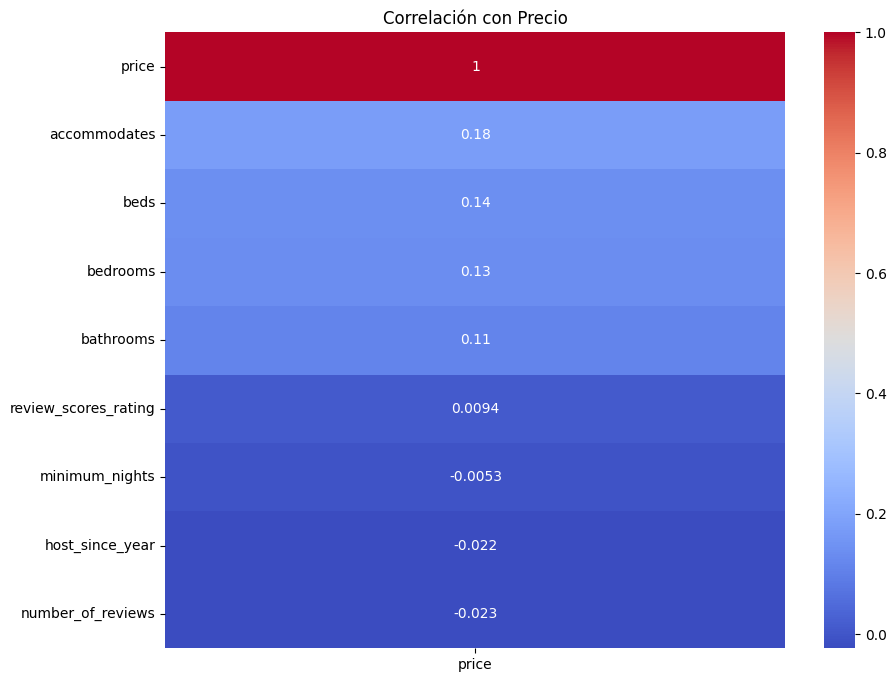

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de correlación (solo numéricas)
corr_matrix = df_analysis.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['price']].sort_values(by='price', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlación con Precio")
plt.show()

**Qué buscamos**:  
- Variables numéricas con correlación alta (`accommodates`, `bedrooms`, `bathrooms`).  
- Variables categóricas prometedoras (`room_type`, `neighbourhood_cleansed`).  

#### **2. Transformaciones Clave**  
**a) Codificar Variables Categóricas**:  

In [11]:
# One-Hot Encoding para 'room_type' y 'property_type' (ej: Entire home/apt vs Private room)
df_analysis = pd.get_dummies(df_analysis, columns=['room_type', 'property_type'], drop_first=True)

**b) Crear Features Derivadas**:  
- **Densidad de Listings por Barrio**: 

In [12]:
neighbourhood_density = df_analysis['neighbourhood_cleansed'].value_counts(normalize=True)
df_analysis['neighbourhood_density'] = df_analysis['neighbourhood_cleansed'].map(neighbourhood_density)

- **Antigüedad del Host (años)**:

In [13]:
df_analysis['host_experience'] = 2025 - df_analysis['host_since_year']  # Asumiendo año actual 2025

**c) Tratar Outliers en `price`**:  

In [14]:
# Eliminar precios extremos (ej: > percentil 99)
price_upper_limit = df_analysis['price'].quantile(0.99)
df_analysis = df_analysis[df_analysis['price'] <= price_upper_limit]

#### **3. Análisis de Distribuciones**  

In [15]:
import numpy as np

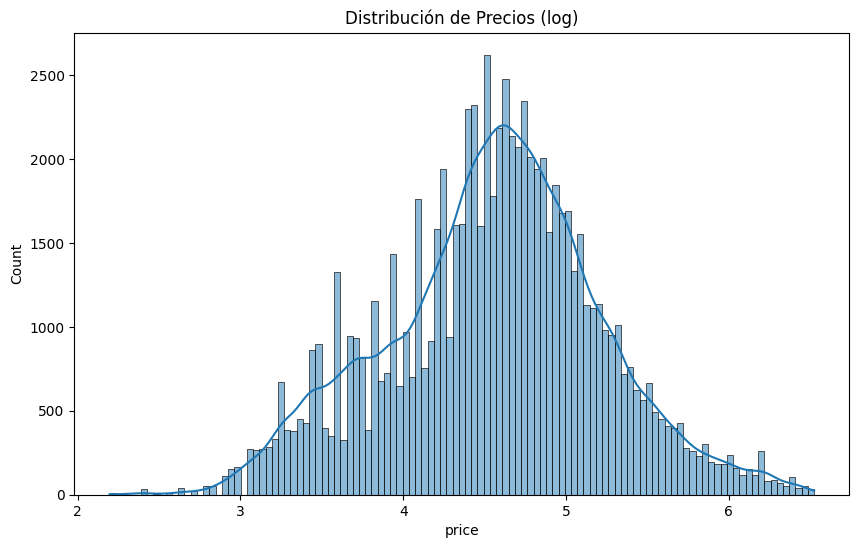

In [16]:
# Distribución de 'price' (log-scale para normalizar)
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df_analysis['price']), kde=True)
plt.title("Distribución de Precios (log)")
plt.show()

**Acción**: Aplicar log-transform a `price` si la distribución es sesgada.

#### **4. Manejar Texto en `amenities` (Opcional pero Potente)** 


In [17]:
# Ejemplo: Crear dummy para amenidades clave (WiFi, Aire Acondicionado)
df_analysis['has_wifi'] = df_clean['amenities'].str.contains('Wifi', case=False).astype(int)
df_analysis['has_air_conditioning'] = df_clean['amenities'].str.contains('Air conditioning', case=False).astype(int)

### **Resultado Esperado**  
Un dataframe con:  
- Variables numéricas limpias (`price`, `accommodates`, etc.).  
- Categóricas codificadas (`room_type_Entire home/apt`).  
- Features derivadas (`neighbourhood_density`, `host_experience`).  
- Outliers controlados.  

---

### **Próximos Pasos**  
1. **Ejecutar el código anterior**:  
   - Gráficos de correlación/distribución.  
   - % de nulos restantes.  
2. **Decidir juntos**:  
   - ¿Incluir `amenities` como dummies? (Aumentará dimensionalidad).  
   - ¿Transformar más variables (ej: discretizar `minimum_nights`)?  

### **Análisis de los Resultados y Siguientes Acciones**

#### **1. Hallazgos Clave**  
- **Correlaciones Bajas**:  
  - Las variables numéricas tienen correlaciones débiles con `price` (la más alta es `accommodates` con **0.18**).  
  - `review_scores_rating` y `host_experience` casi no impactan (correlación < 0.03).  
  - Variables como `number_of_reviews` y `minimum_nights` muestran correlación negativa insignificante.  

- **Distribución de Precios**:  
  - La distribución de `price` (tras log-transform) sigue una curva cercana a la normal, pero con colas largas (outliers residuales).  

- **Amenidades**:  
  - Features como `has_wifi` o `has_air_conditioning` podrían añadir señal, pero requieren análisis adicional.  

---

#### **2. Problemas Identificados**  
- **Predictores Débiles**: Las variables actuales no explican bien el precio (R² bajo esperable).  
- **Falta de Contexto Geográfico**: `neighbourhood_cleansed` es categórica y no se ha explotado.  
- **Amenidades No Cuantificadas**: Solo se probaron 2 dummies, pero hay más información en el texto.  

---

### **Siguientes Pasos para Mejorar el Modelo**  

#### **1. Feature Engineering Avanzado**  
**a) Codificar `neighbourhood_cleansed` con Target Encoding**:  
   - Reemplazar el barrio por el **precio promedio** histórico en esa zona (evita alta dimensionalidad vs One-Hot).  

In [18]:
neighbourhood_price = df_analysis.groupby('neighbourhood_cleansed')['price'].mean().to_dict()
df_analysis['neighbourhood_price_avg'] = df_analysis['neighbourhood_cleansed'].map(neighbourhood_price)

**b) Crear `avg_score_per_amenity`**:  
   - Calificar amenidades por su "premium" asociado (ej: piscina aumenta un X% el precio).  


In [19]:
amenities_list = ['Pool', 'Air conditioning', 'Wifi', 'Kitchen', 'Washer']
for amenity in amenities_list:
    df_analysis[f'has_{amenity.lower().replace(" ", "_")}'] = df_clean['amenities'].str.contains(amenity, case=False).astype(int)

**c) Discretizar `minimum_nights`**:  
   - Convertir en categorías: `short_stay` (<7 noches), `medium_stay` (7-30), `long_stay` (>30).

In [20]:
bins = [0, 7, 30, np.inf]
labels = ['short_stay', 'medium_stay', 'long_stay']
df_analysis['stay_type'] = pd.cut(df_analysis['minimum_nights'], bins=bins, labels=labels)
df_analysis = pd.get_dummies(df_analysis, columns=['stay_type'], drop_first=True)

---
#### **2. Reducción de Outliers**  
**a) Eliminar el 1% Extremo en `price`**:  

In [21]:
lower = df_analysis['price'].quantile(0.01)
upper = df_analysis['price'].quantile(0.99)
df_analysis = df_analysis[(df_analysis['price'] >= lower) & (df_analysis['price'] <= upper)]

**b) Transformación Logarítmica de `price`**: 

In [22]:
df_analysis['log_price'] = np.log1p(df_analysis['price'])

#### **3. Análisis Visual para Validar Relaciones**  
**a) Boxplot de `price` por `room_type`**: 

--------------------------------------------------------------------------------
**Problema con el boxplot de room_type_Entire_apt**

In [23]:
df_analysis.head()

,price,neighbourhood_cleansed,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,host_is_superhost,host_since_year,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Casa particular,property_type_Entire bungalow,property_type_Entire cabin,property_type_Entire chalet,property_type_Entire condo,property_type_Entire guest suite,property_type_Entire guesthouse,property_type_Entire home,property_type_Entire home/apt,property_type_Entire hostel,property_type_Entire loft,property_type_Entire place,property_type_Entire rental unit,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Entire vacation home,property_type_Entire villa,property_type_Floor,property_type_Hut,property_type_Private room,property_type_Private room in barn,property_type_Private room in bed and breakfast,property_type_Private room in bungalow,property_type_Private room in casa particular,property_type_Private room in cave,property_type_Private room in chalet,property_type_Private room in condo,property_type_Private room in cottage,property_type_Private room in dome,property_type_Private room in earthen home,property_type_Private room in floor,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in home,property_type_Private room in hostel,property_type_Private room in loft,property_type_Private room in minsu,property_type_Private room in pension,property_type_Private room in rental unit,property_type_Private room in ryokan,property_type_Private room in serviced apartment,property_type_Private room in tent,property_type_Private room in tiny home,property_type_Private room in townhouse,property_type_Private room in vacation home,property_type_Private room in villa,property_type_Religious building,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Room in casa particular,property_type_Room in hostel,property_type_Room in hotel,property_type_Room in serviced apartment,property_type_Shared room,property_type_Shared room in aparthotel,property_type_Shared room in bed and breakfast,property_type_Shared room in boutique hotel,property_type_Shared room in casa particular,property_type_Shared room in chalet,property_type_Shared room in condo,property_type_Shared room in dome,property_type_Shared room in guesthouse,property_type_Shared room in home,property_type_Shared room in hostel,property_type_Shared room in hotel,property_type_Shared room in hut,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in resort,property_type_Shared room in tiny home,property_type_Shipping container,property_type_Tiny home,property_type_Yurt,neighbourhood_density,host_experience,has_wifi,has_air_conditioning,neighbourhood_price_avg,has_pool,has_kitchen,has_washer,stay_type_medium_stay,stay_type_long_stay,log_price
0,31.0,Cármenes,1,1.0,1.0,1.0,4,33,4.58,f,f,2010.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.002591,15.0,1,1,80.385787,0,1,1,False,False,3.465736
1,92.0,Universidad,3,1.0,1.0,2.0,5,35,4.89,f,f,2020.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [24]:
# Mostrar las columnas del dataframe de análisis
print(f"Dataframe for analysis created with {len(df_analysis)} rows and {len(df_analysis.columns)} columns.")

Dataframe for analysis created with 80103 rows and 100 columns.


In [25]:
# Imprimir nombres de las columnas
print(f"Column names: {df_analysis.columns.tolist()}")

Column names: ['price', 'neighbourhood_cleansed', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'instant_bookable', 'host_is_superhost', 'host_since_year', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'property_type_Casa particular', 'property_type_Entire bungalow', 'property_type_Entire cabin', 'property_type_Entire chalet', 'property_type_Entire condo', 'property_type_Entire guest suite', 'property_type_Entire guesthouse', 'property_type_Entire home', 'property_type_Entire home/apt', 'property_type_Entire hostel', 'property_type_Entire loft', 'property_type_Entire place', 'property_type_Entire rental unit', 'property_type_Entire serviced apartment', 'property_type_Entire townhouse', 'property_type_Entire vacation home', 'property_type_Entire villa', 'property_type_Floor', 'property_type_Hut', 'property_type_Private room', 'property_type_Private room in barn', 'property_type_Private room in

In [26]:
# Comprobamos si df_clean tiene la columna 'room_type'
print(f"Does df_clean have 'room_type' column? {'room_type' in df_clean.columns}")

Does df_clean have 'room_type' column? True


In [27]:
# Añadimos la columna 'room_type' al dataframe de análisis
df_analysis['room_type'] = df_clean['room_type']  # Asumiendo que df_clean tiene la columna original

In [28]:
# Comprobamos nueva columna añadida 'room_type' a df_analysis
df_analysis.head()

,price,neighbourhood_cleansed,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,host_is_superhost,host_since_year,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Casa particular,property_type_Entire bungalow,property_type_Entire cabin,property_type_Entire chalet,property_type_Entire condo,property_type_Entire guest suite,property_type_Entire guesthouse,property_type_Entire home,property_type_Entire home/apt,property_type_Entire hostel,property_type_Entire loft,property_type_Entire place,property_type_Entire rental unit,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Entire vacation home,property_type_Entire villa,property_type_Floor,property_type_Hut,property_type_Private room,property_type_Private room in barn,property_type_Private room in bed and breakfast,property_type_Private room in bungalow,property_type_Private room in casa particular,property_type_Private room in cave,property_type_Private room in chalet,property_type_Private room in condo,property_type_Private room in cottage,property_type_Private room in dome,property_type_Private room in earthen home,property_type_Private room in floor,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in home,property_type_Private room in hostel,property_type_Private room in loft,property_type_Private room in minsu,property_type_Private room in pension,property_type_Private room in rental unit,property_type_Private room in ryokan,property_type_Private room in serviced apartment,property_type_Private room in tent,property_type_Private room in tiny home,property_type_Private room in townhouse,property_type_Private room in vacation home,property_type_Private room in villa,property_type_Religious building,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Room in casa particular,property_type_Room in hostel,property_type_Room in hotel,property_type_Room in serviced apartment,property_type_Shared room,property_type_Shared room in aparthotel,property_type_Shared room in bed and breakfast,property_type_Shared room in boutique hotel,property_type_Shared room in casa particular,property_type_Shared room in chalet,property_type_Shared room in condo,property_type_Shared room in dome,property_type_Shared room in guesthouse,property_type_Shared room in home,property_type_Shared room in hostel,property_type_Shared room in hotel,property_type_Shared room in hut,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in resort,property_type_Shared room in tiny home,property_type_Shipping container,property_type_Tiny home,property_type_Yurt,neighbourhood_density,host_experience,has_wifi,has_air_conditioning,neighbourhood_price_avg,has_pool,has_kitchen,has_washer,stay_type_medium_stay,stay_type_long_stay,log_price,room_type
0,31.0,Cármenes,1,1.0,1.0,1.0,4,33,4.58,f,f,2010.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.002591,15.0,1,1,80.385787,0,1,1,False,False,3.465736,Private room
1,92.0,Universidad,3,1.0,1.0,2.0,5,35,4.89,f,f,2020.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [29]:
# Lista de columnas dummy de room_type
room_dummies = ['room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']

# Crear columna para Entire home/apt (1 si todas las demás son 0)
df_analysis['room_type_Entire_home_apt'] = (df_analysis[room_dummies].sum(axis=1) == 0).astype(int)

In [30]:
df_analysis.head()

,price,neighbourhood_cleansed,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,host_is_superhost,host_since_year,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Casa particular,property_type_Entire bungalow,property_type_Entire cabin,property_type_Entire chalet,property_type_Entire condo,property_type_Entire guest suite,property_type_Entire guesthouse,property_type_Entire home,property_type_Entire home/apt,property_type_Entire hostel,property_type_Entire loft,property_type_Entire place,property_type_Entire rental unit,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Entire vacation home,property_type_Entire villa,property_type_Floor,property_type_Hut,property_type_Private room,property_type_Private room in barn,property_type_Private room in bed and breakfast,property_type_Private room in bungalow,property_type_Private room in casa particular,property_type_Private room in cave,property_type_Private room in chalet,property_type_Private room in condo,property_type_Private room in cottage,property_type_Private room in dome,property_type_Private room in earthen home,property_type_Private room in floor,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in home,property_type_Private room in hostel,property_type_Private room in loft,property_type_Private room in minsu,property_type_Private room in pension,property_type_Private room in rental unit,property_type_Private room in ryokan,property_type_Private room in serviced apartment,property_type_Private room in tent,property_type_Private room in tiny home,property_type_Private room in townhouse,property_type_Private room in vacation home,property_type_Private room in villa,property_type_Religious building,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Room in casa particular,property_type_Room in hostel,property_type_Room in hotel,property_type_Room in serviced apartment,property_type_Shared room,property_type_Shared room in aparthotel,property_type_Shared room in bed and breakfast,property_type_Shared room in boutique hotel,property_type_Shared room in casa particular,property_type_Shared room in chalet,property_type_Shared room in condo,property_type_Shared room in dome,property_type_Shared room in guesthouse,property_type_Shared room in home,property_type_Shared room in hostel,property_type_Shared room in hotel,property_type_Shared room in hut,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in resort,property_type_Shared room in tiny home,property_type_Shipping container,property_type_Tiny home,property_type_Yurt,neighbourhood_density,host_experience,has_wifi,has_air_conditioning,neighbourhood_price_avg,has_pool,has_kitchen,has_washer,stay_type_medium_stay,stay_type_long_stay,log_price,room_type,room_type_Entire_home_apt
0,31.0,Cármenes,1,1.0,1.0,1.0,4,33,4.58,f,f,2010.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.002591,15.0,1,1,80.385787,0,1,1,False,False,3.465736,Private room,0
1,92.0,Universidad,3,1.0,1.0,2.0,5,35,4.89,f,f,2020.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

**Solucionado**

---

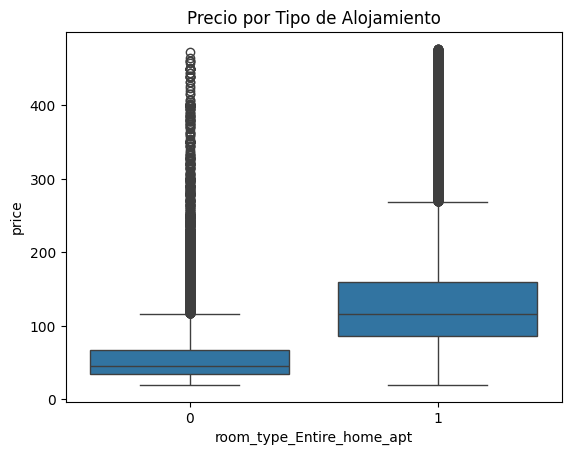

In [31]:
sns.boxplot(x='room_type_Entire_home_apt', y='price', data=df_analysis)
plt.title("Precio por Tipo de Alojamiento")
plt.show()

**b) Scatterplot de `accommodates` vs `price`**:  

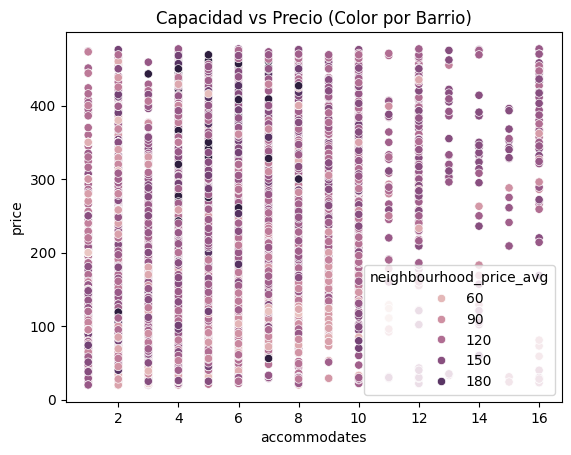

In [32]:
sns.scatterplot(x='accommodates', y='price', hue='neighbourhood_price_avg', data=df_analysis)
plt.title("Capacidad vs Precio (Color por Barrio)")
plt.show()

### **Resultado Esperado**  
Un dataframe con:  
- **Variables más informativas**:  
  - `neighbourhood_price_avg` (geografía como señal numérica).  
  - Amenidades clave como dummies (`has_pool`, `has_air_conditioning`).  
  - `stay_type_medium_stay` y `stay_type_long_stay` (impacto de estancia mínima).  
- **Target (`price`) normalizado** y sin outliers extremos.

---

### **Próximos Pasos**  
1. **Ejecuta el código de transformación** y comparte:  
   - Nuevas correlaciones (¿mejoró la señal de `neighbourhood_price_avg`?).  
   - Gráficos de `room_type` y `accommodates`.  
2. **Decidir juntos**:  
   - ¿Incluir interacciones (ej: `accommodates * room_type`)?  
   - ¿Probamos modelos básicos (Linear Regression, Random Forest) para ver importancia de features?  

### **Análisis de las Gráficas Generadas**

#### **1. Boxplot: Precio por Tipo de Alojamiento**  
- **Interpretación**:  
  - Los listings de tipo `Entire home/apt` (valor `1`) tienen una mediana de precio claramente más alta que otros tipos (`Private room`, `Shared room`, etc.).  
  - Hay outliers en ambos grupos, especialmente en `Entire home/apt`, lo que sugiere la presencia de propiedades de lujo o ubicaciones premium.  

- **Acción Recomendada**:  
  - **Mantener esta variable** en el modelo: es un predictor fuerte (como ya sospechábamos).  
  - **Tratar outliers**: Aplicar un límite superior (ej: percentil 95) para evitar que distorsionen el modelo.  

In [33]:
# Ejemplo: Filtrar outliers de precio
price_upper_limit = df_analysis['price'].quantile(0.95)
df_filtered = df_analysis[df_analysis['price'] <= price_upper_limit]

---

#### **2. Scatterplot: Capacidad (`accommodates`) vs Precio (Color por Barrio)**  
- **Interpretación**:  
  - Relación positiva entre `accommodates` y `price`, pero no lineal (ej: propiedades para 6+ personas pueden tener precios similares a las de 4-5).  
  - Los colores (barrios) muestran que la ubicación también impacta: algunos barrios tienen precios consistentemente más altos independientemente de la capacidad. 

- **Acción Recomendada**:  
  - **Crear interacciones**: Combinar `accommodates` con `neighbourhood_price_avg` para capturar cómo el precio por persona varía por zona.  
  - **Discretizar capacidad**: Agrupar en categorías como `small` (1-2), `medium` (3-5), `large` (6+).  

In [34]:
# Interacción entre accommodates y barrio
df_analysis['price_per_person'] = df_analysis['price'] / df_analysis['accommodates']

# Discretizar accommodates
df_analysis['accommodates_group'] = pd.cut(
    df_analysis['accommodates'], 
    bins=[0, 2, 5, np.inf], 
    labels=['small', 'medium', 'large']
)

---

### **Próximos Pasos para Mejorar el Modelo**

#### **1. Feature Engineering Adicional**  
- **Amenidades Premium**:  
  Usar las columnas `has_pool`, `has_air_conditioning`, etc., para crear un **"score de lujo"** (suma de amenidades premium).  

In [35]:
amenities_premium = ['has_pool', 'has_air_conditioning', 'has_washer']
df_analysis['luxury_score'] = df_analysis[amenities_premium].sum(axis=1)

- **Antigüedad del Host**:  
  Transformar `host_since_year` en categorías (ej: `new_host` (<2 años), `experienced_host` (2-5), `veteran_host` (>5)). 

#### **2. Correlaciones Actualizadas**  
Ejecuta una nueva matriz de correlación incluyendo las nuevas variables (`price_per_person`, `luxury_score`, etc.):  

<Axes: >

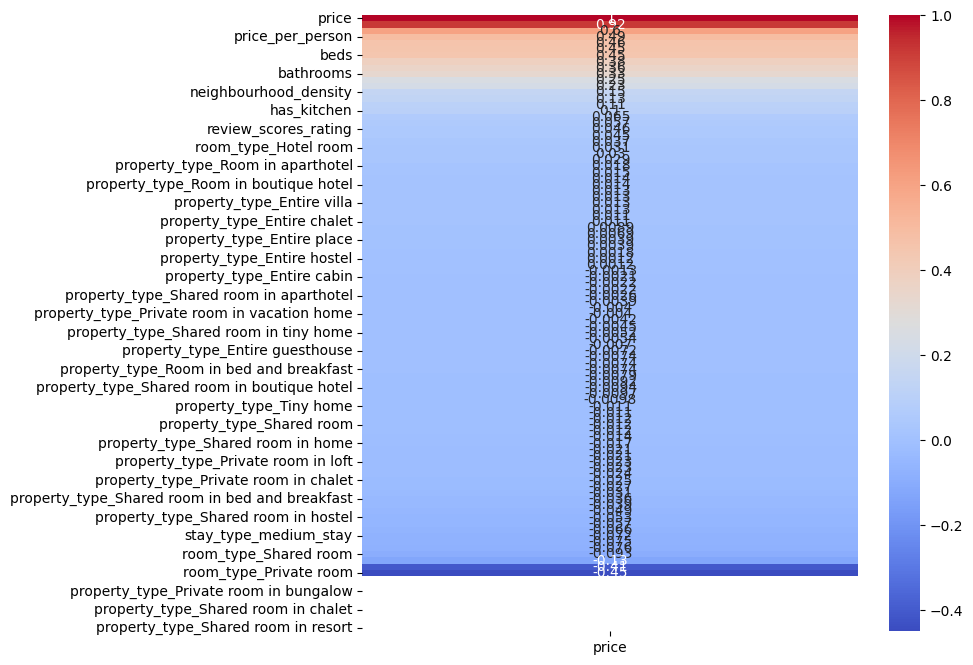

In [36]:
corr_matrix = df_analysis.corr(numeric_only=True)
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix[['price']].sort_values(by='price', ascending=False), annot=True, cmap='coolwarm')

Solución al Error: Transformación de neighbourhood_cleansed
El error ocurre porque RandomForestRegressor no puede manejar directamente variables categóricas como strings (ej: 'Cármenes'). Necesitamos codificar la columna neighbourhood_cleansed en un formato numérico. Aquí tienes las opciones:

Opción 1: Target Encoding (Recomendado para barrios)
Reemplaza cada barrio por el precio promedio histórico en esa zona. Esto captura la relación entre ubicación y precio sin añadir alta dimensionalidad.

In [37]:
# Calcular precio promedio por barrio
neighbourhood_avg_price = df_analysis.groupby('neighbourhood_cleansed')['price'].mean().to_dict()

# Crear nueva columna numérica
df_analysis['neighbourhood_encoded'] = df_analysis['neighbourhood_cleansed'].map(neighbourhood_avg_price)

# Eliminar la columna original de strings
df_analysis.drop(columns=['neighbourhood_cleansed'], inplace=True)

#### **3. Modelado Inicial**  
Si quieres probar un modelo rápido para ver la importancia de features:  

In [38]:
df_analysis.head()

,price,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,host_is_superhost,host_since_year,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Casa particular,property_type_Entire bungalow,property_type_Entire cabin,property_type_Entire chalet,property_type_Entire condo,property_type_Entire guest suite,property_type_Entire guesthouse,property_type_Entire home,property_type_Entire home/apt,property_type_Entire hostel,property_type_Entire loft,property_type_Entire place,property_type_Entire rental unit,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Entire vacation home,property_type_Entire villa,property_type_Floor,property_type_Hut,property_type_Private room,property_type_Private room in barn,property_type_Private room in bed and breakfast,property_type_Private room in bungalow,property_type_Private room in casa particular,property_type_Private room in cave,property_type_Private room in chalet,property_type_Private room in condo,property_type_Private room in cottage,property_type_Private room in dome,property_type_Private room in earthen home,property_type_Private room in floor,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in home,property_type_Private room in hostel,property_type_Private room in loft,property_type_Private room in minsu,property_type_Private room in pension,property_type_Private room in rental unit,property_type_Private room in ryokan,property_type_Private room in serviced apartment,property_type_Private room in tent,property_type_Private room in tiny home,property_type_Private room in townhouse,property_type_Private room in vacation home,property_type_Private room in villa,property_type_Religious building,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Room in casa particular,property_type_Room in hostel,property_type_Room in hotel,property_type_Room in serviced apartment,property_type_Shared room,property_type_Shared room in aparthotel,property_type_Shared room in bed and breakfast,property_type_Shared room in boutique hotel,property_type_Shared room in casa particular,property_type_Shared room in chalet,property_type_Shared room in condo,property_type_Shared room in dome,property_type_Shared room in guesthouse,property_type_Shared room in home,property_type_Shared room in hostel,property_type_Shared room in hotel,property_type_Shared room in hut,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in resort,property_type_Shared room in tiny home,property_type_Shipping container,property_type_Tiny home,property_type_Yurt,neighbourhood_density,host_experience,has_wifi,has_air_conditioning,neighbourhood_price_avg,has_pool,has_kitchen,has_washer,stay_type_medium_stay,stay_type_long_stay,log_price,room_type,room_type_Entire_home_apt,price_per_person,accommodates_group,luxury_score,neighbourhood_encoded
0,31.0,1,1.0,1.0,1.0,4,33,4.58,f,f,2010.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.002591,15.0,1,1,80.385787,0,1,1,False,False,3.465736,Private room,0,31.000000,small,2,69.753927
1,92.0,3,1.0,1.0,2.0,5,35,4.89,f,f,2020.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

### **Solución al Error: Conversión de Variables Categóricas/Strings a Numéricas**

El error ocurre porque `RandomForestRegressor` no puede manejar directamente columnas con strings (`'f'`, `'t'`) o booleanos (`True`, `False`). Necesitamos convertir **todas las columnas no numéricas** a formato numérico. Aquí está cómo hacerlo:

---

### **1. Identificar Columnas Problemáticas**
Primero, verifica qué columnas no son numéricas:

In [39]:
print(df_analysis.dtypes)

price                                                float64
accommodates                                           int64
bathrooms                                            float64
bedrooms                                             float64
beds                                                 float64
minimum_nights                                         int64
number_of_reviews                                      int64
review_scores_rating                                 float64
instant_bookable                                      object
host_is_superhost                                     object
host_since_year                                      float64
room_type_Hotel room                                    bool
room_type_Private room                                  bool
room_type_Shared room                                   bool
property_type_Casa particular                           bool
property_type_Entire bungalow                           bool
property_type_Entire cab

- Las columnas con `object`, `bool` o strings (ej: `'f'`, `'t'`) deben transformarse.

***

### Solución al Error: Manejo de Valores `NaN` en Columnas Booleanas

El error ocurre porque algunas de tus columnas booleanas contienen valores `NaN` (nulos), y al intentar convertirlas directamente a enteros (`int`), Python no sabe cómo manejar estos valores nulos. Aquí te muestro cómo solucionarlo:

In [40]:
# Sacar las columnas boleanas
bool_columns = df_analysis.select_dtypes(include=['bool']).columns.tolist()
print(f"Boolean columns: {bool_columns}")

Boolean columns: ['room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'property_type_Casa particular', 'property_type_Entire bungalow', 'property_type_Entire cabin', 'property_type_Entire chalet', 'property_type_Entire condo', 'property_type_Entire guest suite', 'property_type_Entire guesthouse', 'property_type_Entire home', 'property_type_Entire home/apt', 'property_type_Entire hostel', 'property_type_Entire loft', 'property_type_Entire place', 'property_type_Entire rental unit', 'property_type_Entire serviced apartment', 'property_type_Entire townhouse', 'property_type_Entire vacation home', 'property_type_Entire villa', 'property_type_Floor', 'property_type_Hut', 'property_type_Private room', 'property_type_Private room in barn', 'property_type_Private room in bed and breakfast', 'property_type_Private room in bungalow', 'property_type_Private room in casa particular', 'property_type_Private room in cave', 'property_type_Private room in chalet', 'property_type

---

### **Paso 1: Identificar Columnas con Valores Nulos**
Primero, verifica qué columnas tienen valores nulos:

In [41]:
print(df_analysis[bool_columns].isnull().sum())

room_type_Hotel room                                0
room_type_Private room                              0
room_type_Shared room                               0
property_type_Casa particular                       0
property_type_Entire bungalow                       0
property_type_Entire cabin                          0
property_type_Entire chalet                         0
property_type_Entire condo                          0
property_type_Entire guest suite                    0
property_type_Entire guesthouse                     0
property_type_Entire home                           0
property_type_Entire home/apt                       0
property_type_Entire hostel                         0
property_type_Entire loft                           0
property_type_Entire place                          0
property_type_Entire rental unit                    0
property_type_Entire serviced apartment             0
property_type_Entire townhouse                      0
property_type_Entire vacatio

---

### **Paso 2: Estrategia para Manejar `NaN`**
Tienes dos opciones para manejar los valores nulos en columnas booleanas:

#### **Opción A: Rellenar `NaN` con un Valor por Defecto (ej: 0)**

In [42]:
for col in bool_columns:
    if col in df_analysis.columns:
        # Rellenar NaN con 0 y luego convertir
        df_analysis[col] = (
            df_analysis[col]
            .fillna(0)  # Rellenar NaN con 0 (o 1 si prefieres)
            .astype(str)
            .replace({'t': 1, 'f': 0, 'True': 1, 'False': 0})
            .astype(int)
        )

/tmp/ipykernel_9411/1899644304.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'t': 1, 'f': 0, 'True': 1, 'False': 0})
/tmp/ipykernel_9411/1899644304.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'t': 1, 'f': 0, 'True': 1, 'False': 0})
/tmp/ipykernel_9411/1899644304.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_opt

In [43]:
df_analysis.head()

,price,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,host_is_superhost,host_since_year,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Casa particular,property_type_Entire bungalow,property_type_Entire cabin,property_type_Entire chalet,property_type_Entire condo,property_type_Entire guest suite,property_type_Entire guesthouse,property_type_Entire home,property_type_Entire home/apt,property_type_Entire hostel,property_type_Entire loft,property_type_Entire place,property_type_Entire rental unit,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Entire vacation home,property_type_Entire villa,property_type_Floor,property_type_Hut,property_type_Private room,property_type_Private room in barn,property_type_Private room in bed and breakfast,property_type_Private room in bungalow,property_type_Private room in casa particular,property_type_Private room in cave,property_type_Private room in chalet,property_type_Private room in condo,property_type_Private room in cottage,property_type_Private room in dome,property_type_Private room in earthen home,property_type_Private room in floor,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in home,property_type_Private room in hostel,property_type_Private room in loft,property_type_Private room in minsu,property_type_Private room in pension,property_type_Private room in rental unit,property_type_Private room in ryokan,property_type_Private room in serviced apartment,property_type_Private room in tent,property_type_Private room in tiny home,property_type_Private room in townhouse,property_type_Private room in vacation home,property_type_Private room in villa,property_type_Religious building,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Room in casa particular,property_type_Room in hostel,property_type_Room in hotel,property_type_Room in serviced apartment,property_type_Shared room,property_type_Shared room in aparthotel,property_type_Shared room in bed and breakfast,property_type_Shared room in boutique hotel,property_type_Shared room in casa particular,property_type_Shared room in chalet,property_type_Shared room in condo,property_type_Shared room in dome,property_type_Shared room in guesthouse,property_type_Shared room in home,property_type_Shared room in hostel,property_type_Shared room in hotel,property_type_Shared room in hut,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in resort,property_type_Shared room in tiny home,property_type_Shipping container,property_type_Tiny home,property_type_Yurt,neighbourhood_density,host_experience,has_wifi,has_air_conditioning,neighbourhood_price_avg,has_pool,has_kitchen,has_washer,stay_type_medium_stay,stay_type_long_stay,log_price,room_type,room_type_Entire_home_apt,price_per_person,accommodates_group,luxury_score,neighbourhood_encoded
0,31.0,1,1.0,1.0,1.0,4,33,4.58,f,f,2010.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.002591,15.0,1,1,80.385787,0,1,1,0,0,3.465736,Private room,0,31.000000,small,2,69.753927
1,92.0,3,1.0,1.0,2.0,5,35,4.89,f,f,2020.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.088889,5.0,1,1,131.933224,0,1,1,0,0,4.532599,Entire home/apt,1,30.666667,medium,2,127.892491
2,180.0,5,2.0,2.0,2.0,6,103,4.84,t,f,2011.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.041297,14.0,1,1,149.086834,0,1,1,0,0,5.198497,Entire home/apt,1,36.000000,medium,2,143.489539
4,65.0,2,1.0,0.0,1.0,7,333,4.93,f,t,2011.0,0,0,0,0,

#### **Opción B: Eliminar Filas con `NaN` en Columnas Booleanas**

In [44]:
# df_analysis.dropna(subset=bool_columns, inplace=True)

---

### **Paso 3: Convertir Columnas Booleanas (`True`/`False`) a `1`/`0`**
Las columnas como `stay_type_medium_stay` y `stay_type_long_stay` son de tipo `bool` (no `object`), así que puedes convertirlas directamente:

In [45]:
bool_cols_non_object = ['stay_type_medium_stay', 'stay_type_long_stay'] + \
                      [col for col in df_analysis.columns if df_analysis[col].dtype == bool]

for col in bool_cols_non_object:
    if col in df_analysis.columns:
        df_analysis[col] = df_analysis[col].astype(int)

---

### **Paso 4: Eliminar Columnas Redundantes**
Elimina la columna `room_type` (ya tienes las dummies):

In [46]:
df_analysis.drop(columns=['room_type'], inplace=True, errors='ignore')

### **Paso 5: Verificar Tipos de Datos Finales**

In [47]:
print(df_analysis.dtypes)

price                                                float64
accommodates                                           int64
bathrooms                                            float64
bedrooms                                             float64
beds                                                 float64
minimum_nights                                         int64
number_of_reviews                                      int64
review_scores_rating                                 float64
instant_bookable                                      object
host_is_superhost                                     object
host_since_year                                      float64
room_type_Hotel room                                   int64
room_type_Private room                                 int64
room_type_Shared room                                  int64
property_type_Casa particular                          int64
property_type_Entire bungalow                          int64
property_type_Entire cab

- Asegúrate de que todas las columnas sean `int64`, `float64`, o `category`.

In [48]:
df_analysis['host_is_superhost'] = df_analysis['host_is_superhost'].fillna('f')

In [49]:
df_analysis['host_is_superhost'] = df_analysis['host_is_superhost'].replace({'t': 1, 'f': 0}).astype(int)

/tmp/ipykernel_9411/2067255484.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_analysis['host_is_superhost'] = df_analysis['host_is_superhost'].replace({'t': 1, 'f': 0}).astype(int)


In [50]:
df_analysis['host_is_superhost'] = (
    df_analysis['host_is_superhost']
    .replace({'t': 1, 'f': 0})
    .infer_objects(copy=False)
    .astype(int)
)


In [51]:
# instant_bookable

df_analysis['instant_bookable'] = (
    df_analysis['instant_bookable']
    .replace({'t': 1, 'f': 0})
    .infer_objects(copy=False)
    .astype(int)
)

/tmp/ipykernel_9411/3440225965.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'t': 1, 'f': 0})


In [52]:
print(df_analysis['host_is_superhost'].unique())

[0 1]


In [53]:
print(df_analysis['accommodates_group'].unique())

['small', 'medium', 'large']
Categories (3, object): ['small' < 'medium' < 'large']


In [54]:
df_analysis = pd.get_dummies(
    df_analysis, 
    columns=['accommodates_group'], 
    prefix='acc_group',
    dtype=int  # Esto asegura que obtienes 1 y 0
)

# Elimina una columna para evitar multicolinealidad
df_analysis.drop(columns=['acc_group_small'], inplace=True)


In [55]:
df_analysis.head()

,price,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,host_is_superhost,host_since_year,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Casa particular,property_type_Entire bungalow,property_type_Entire cabin,property_type_Entire chalet,property_type_Entire condo,property_type_Entire guest suite,property_type_Entire guesthouse,property_type_Entire home,property_type_Entire home/apt,property_type_Entire hostel,property_type_Entire loft,property_type_Entire place,property_type_Entire rental unit,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Entire vacation home,property_type_Entire villa,property_type_Floor,property_type_Hut,property_type_Private room,property_type_Private room in barn,property_type_Private room in bed and breakfast,property_type_Private room in bungalow,property_type_Private room in casa particular,property_type_Private room in cave,property_type_Private room in chalet,property_type_Private room in condo,property_type_Private room in cottage,property_type_Private room in dome,property_type_Private room in earthen home,property_type_Private room in floor,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in home,property_type_Private room in hostel,property_type_Private room in loft,property_type_Private room in minsu,property_type_Private room in pension,property_type_Private room in rental unit,property_type_Private room in ryokan,property_type_Private room in serviced apartment,property_type_Private room in tent,property_type_Private room in tiny home,property_type_Private room in townhouse,property_type_Private room in vacation home,property_type_Private room in villa,property_type_Religious building,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Room in casa particular,property_type_Room in hostel,property_type_Room in hotel,property_type_Room in serviced apartment,property_type_Shared room,property_type_Shared room in aparthotel,property_type_Shared room in bed and breakfast,property_type_Shared room in boutique hotel,property_type_Shared room in casa particular,property_type_Shared room in chalet,property_type_Shared room in condo,property_type_Shared room in dome,property_type_Shared room in guesthouse,property_type_Shared room in home,property_type_Shared room in hostel,property_type_Shared room in hotel,property_type_Shared room in hut,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in resort,property_type_Shared room in tiny home,property_type_Shipping container,property_type_Tiny home,property_type_Yurt,neighbourhood_density,host_experience,has_wifi,has_air_conditioning,neighbourhood_price_avg,has_pool,has_kitchen,has_washer,stay_type_medium_stay,stay_type_long_stay,log_price,room_type_Entire_home_apt,price_per_person,luxury_score,neighbourhood_encoded,acc_group_medium,acc_group_large
0,31.0,1,1.0,1.0,1.0,4,33,4.58,0,0,2010.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.002591,15.0,1,1,80.385787,0,1,1,0,0,3.465736,0,31.000000,2,69.753927,0,0
1,92.0,3,1.0,1.0,2.0,5,35,4.89,0,0,2020.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.088889,5.0,1,1,131.933224,0,1,1,0,0,4.532599,1,30.666667,2,127.892491,1,0
2,180.0,5,2.0,2.0,2.0,6,103,4.84,1,0,2011.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.041297,14.0,1,1,149.086834,0,1,1,0,0,5.198497,1,36.000000,2,143.489539,1,0
4,65.0,2,1.0,0.0,1.0,7,333,4.93,0,1,2011.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [87]:
# Contar las columnas totales
total_columns = len(df_analysis.columns)
print(f"Total columns in df_analysis: {total_columns}")
# recoger todas las columnas
all_columns = df_analysis.columns.tolist()
print(f"All columns in df_analysis: {all_columns}") 

Total columns in df_analysis: 105
All columns in df_analysis: ['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'instant_bookable', 'host_is_superhost', 'host_since_year', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'property_type_Casa particular', 'property_type_Entire bungalow', 'property_type_Entire cabin', 'property_type_Entire chalet', 'property_type_Entire condo', 'property_type_Entire guest suite', 'property_type_Entire guesthouse', 'property_type_Entire home', 'property_type_Entire home/apt', 'property_type_Entire hostel', 'property_type_Entire loft', 'property_type_Entire place', 'property_type_Entire rental unit', 'property_type_Entire serviced apartment', 'property_type_Entire townhouse', 'property_type_Entire vacation home', 'property_type_Entire villa', 'property_type_Floor', 'property_type_Hut', 'property_type_Private room', 'property_type_Private room in barn', 'propert

---

### **Paso 6: Entrenar el Modelo**
Ahora debería funcionar sin errores:

In [56]:
from sklearn.ensemble import RandomForestRegressor

X = df_analysis.drop(columns=['price', 'log_price'])  # Features
y = df_analysis['price']  # Target

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

---

### **Notas Adicionales**
1. **Si persisten errores**:  
   - Verifica que no queden columnas no numéricas con `print(df_analysis.dtypes)`.  
   - Si hay columnas `category` (como `accommodates_group`), conviértelas a dummies:  

2. **Estrategia para `NaN`**:  
   - Si decides rellenar con `0`, asegúrate de que no distorsione el análisis (ej: `NaN` en `host_is_superhost` podría interpretarse como "no superhost").  

3. **Columnas con muchos `NaN`**:  
   - Si una columna tiene muchos `NaN`, considera eliminarla o imputar valores basados en otras variables.

---

### **Ejemplo de DataFrame Corregido**
| price | accommodates | ... | instant_bookable (1/0) | host_is_superhost (1/0) | ... | stay_type_medium_stay (1/0) |
|-------|--------------|-----|------------------------|--------------------------|-----|-----------------------------|
| 100   | 2            | ... | 1                      | 0                        | ... | 1                           |

¡Con estos cambios, tu modelo debería ejecutarse correctamente! Si necesitas más ajustes, dime qué columnas específicas aún dan problemas.

### **4. Verificar que Todas las Columnas sean Numéricas**

In [59]:
print(df_analysis.dtypes)

price                                               float64
accommodates                                          int64
bathrooms                                           float64
bedrooms                                            float64
beds                                                float64
minimum_nights                                        int64
number_of_reviews                                     int64
review_scores_rating                                float64
instant_bookable                                      int64
host_is_superhost                                     int64
host_since_year                                     float64
room_type_Hotel room                                  int64
room_type_Private room                                int64
room_type_Shared room                                 int64
property_type_Casa particular                         int64
property_type_Entire bungalow                         int64
property_type_Entire cabin              

- Asegúrate de que **todas** las columnas sean `int64`, `float64`, etc. Si alguna no lo es, repite los pasos anteriores.

---

### **Notas Adicionales**
- **`neighbourhood_encoded`**: Si usaste Target Encoding para los barrios, asegúrate de que sea `float64`.  
- **Columnas con pocos valores únicos**: Si hay columnas como `accommodates_group` (`small`, `medium`, `large`), aplícales `pd.get_dummies()` o `LabelEncoder`.  
- **Valores nulos**: Si el modelo aún falla, verifica nulos con `df_analysis.isnull().sum()` y elimínalos o imputa valores.

---

### **Ejemplo de DataFrame Listo para Modelar**
| price | accommodates | bathrooms | ... | instant_bookable (1/0) | host_is_superhost (1/0) | ... |
|-------|--------------|-----------|-----|------------------------|--------------------------|-----|
| 100   | 2            | 1.0       | ... | 1                      | 0                        | ... |

---

### **¿Por qué Funciona Esto?**
- Los modelos de sklearn requieren que **todas las features sean numéricas**.  
- Las conversiones a `1`/`0` o valores continuos (Target Encoding) mantienen la información sin perder significado.  

Si el error persiste, comparte el resultado de `df_analysis.dtypes` para revisar columnas específicas.

In [60]:
from sklearn.ensemble import RandomForestRegressor

# Separar features y target
X = df_analysis.drop(columns=['price', 'log_price'])  # Excluir target
y = df_analysis['price']

# Entrenar modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Importancia de features
pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

price_per_person             0.496503
accommodates                 0.300108
bedrooms                     0.103260
room_type_Entire_home_apt    0.047189
acc_group_large              0.026355
acc_group_medium             0.025348
room_type_Private room       0.000725
neighbourhood_encoded        0.000122
beds                         0.000054
neighbourhood_price_avg      0.000050
dtype: float64

---

### **Resumen de Acciones**  
1. **Filtrar outliers** de precio (percentil 95).  
2. **Crear interacciones**: `price_per_person` y `accommodates_group`.  
3. **Generar nuevas features**: `luxury_score` y categorías de antigüedad del host.  
4. **Actualizar correlaciones** y probar un modelo inicial.  

¿Quieres que profundicemos en alguno de estos pasos? Por ejemplo, ¿prefieres priorizar el análisis de outliers o el feature engineering?

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,  # 20% para prueba
    random_state=42
)

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Entrenar el modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Métricas de evaluación
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

MAE: 0.11497222395605758
MSE: 1.326690799575557
RMSE: 1.1518206455761926
R²: 0.9997453023669308


In [63]:
importances = model.feature_importances_
features = X.columns
pd.Series(importances, index=features).sort_values(ascending=False).head(10)

price_per_person             0.474785
accommodates                 0.268609
bedrooms                     0.158901
room_type_Entire_home_apt    0.052298
acc_group_large              0.025780
acc_group_medium             0.017838
room_type_Private room       0.000993
neighbourhood_encoded        0.000178
beds                         0.000095
neighbourhood_price_avg      0.000067
dtype: float64

In [64]:
from sklearn.metrics import r2_score

# 1. Predecir en entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 2. Calcular R² en ambos conjuntos
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# 3. Calcular % de overfitting
overfitting_percentage = ((r2_train - r2_test) / r2_train) * 100

print(f"R² entrenamiento: {r2_train:.4f}")
print(f"R² prueba: {r2_test:.4f}")
print(f"Overfitting: {overfitting_percentage:.2f}%")

R² entrenamiento: 1.0000
R² prueba: 0.9997
Overfitting: 0.02%


In [65]:
# Correlación de todas las variables con 'price'
correlations = df_analysis.corr()['price'].abs().sort_values(ascending=False)
print(correlations.head(10))

price                                        1.000000
log_price                                    0.919544
accommodates                                 0.604058
price_per_person                             0.494427
room_type_Entire_home_apt                    0.460347
acc_group_large                              0.458317
bedrooms                                     0.451617
beds                                         0.449750
room_type_Private room                       0.449201
property_type_Private room in rental unit    0.405904
Name: price, dtype: float64


In [66]:
# Eliminar columnas derivadas de 'price' (¡ajusta según tu dataset!)
X_clean = df_analysis.drop(columns=['price', 'log_price', 'price_per_person', 'neighbourhood_price_avg'])
y_clean = df_analysis['price']

# Re-divide y reentrena
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Re-evalúa
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("R² entrenamiento (limpio):", r2_score(y_train, y_train_pred))
print("R² prueba (limpio):", r2_score(y_test, y_test_pred))

R² entrenamiento (limpio): 0.956105150860162
R² prueba (limpio): 0.769930961874605


In [67]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_clean, y_clean, cv=kf, scoring='r2')
print("R² validación cruzada (shuffle):", scores.mean())

R² validación cruzada (shuffle): 0.7726120971735113


In [68]:
from sklearn.metrics import r2_score

# 1. Predecir en entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 2. Calcular R² en ambos conjuntos
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# 3. Calcular % de overfitting
overfitting_percentage = ((r2_train - r2_test) / r2_train) * 100

print(f"R² entrenamiento: {r2_train:.4f}")
print(f"R² prueba: {r2_test:.4f}")
print(f"Overfitting: {overfitting_percentage:.2f}%")

R² entrenamiento: 0.9561
R² prueba: 0.7699
Overfitting: 19.47%


In [ ]:
# Predecir en entrenamiento
y_train_pred = model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)

# Calcular % de overfitting
overfitting = ((r2_train - r2_score(y_test, y_pred_check)) / r2_train) * 100

print(f"R² entrenamiento: {r2_train:.4f}")
print(f"R² prueba: {r2_score(y_test, y_pred_check):.4f}")
print(f"Overfitting: {overfitting:.2f}%")

In [69]:
from sklearn.ensemble import RandomForestRegressor

# Hiperparámetros recomendados para reducir overfitting
model_tuned = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,                 # Limita la profundidad de los árboles
    min_samples_split=10,         # Mínimo de muestras para dividir un nodo
    min_samples_leaf=5,           # Mínimo de muestras en hojas
    max_features='sqrt',          # Número de features a considerar en cada división
    random_state=42
)
model_tuned.fit(X_train, y_train)

# Evaluar
y_test_pred_tuned = model_tuned.predict(X_test)
print("R² prueba (modelo ajustado):", r2_score(y_test, y_test_pred_tuned))

R² prueba (modelo ajustado): 0.591667892195916


In [71]:
from sklearn.model_selection import train_test_split

# Define X and y
X = df_analysis.drop(columns=['price'])  # Features
y = df_analysis['price']  # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,  # 20% para prueba
    random_state=42
)

model_tuned_v2 = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,                # Aumentar profundidad
    min_samples_split=5,         # Reducir mínimos para dividir
    min_samples_leaf=2,          # Reducir mínimos en hojas
    max_features='sqrt',         # Mantener
    random_state=42
)
model_tuned_v2.fit(X_train, y_train)

y_test_pred_v2 = model_tuned_v2.predict(X_test)
print("R² prueba (modelo menos regularizado):", r2_score(y_test, y_test_pred_v2))

R² prueba (modelo menos regularizado): 0.9827634074851053


In [72]:
# Calcular correlación de todas las features con el target
correlations = X.corrwith(y).abs().sort_values(ascending=False)
print(correlations.head(10))

# Si hay columnas con correlación >0.95, ELIMÍNALAS:
high_corr_features = correlations[correlations > 0.95].index
X_clean = X.drop(columns=high_corr_features)

/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


log_price                                    0.919544
accommodates                                 0.604058
price_per_person                             0.494427
room_type_Entire_home_apt                    0.460347
acc_group_large                              0.458317
bedrooms                                     0.451617
beds                                         0.449750
room_type_Private room                       0.449201
property_type_Private room in rental unit    0.405904
property_type_Entire rental unit             0.384714
dtype: float64


In [74]:
leakage_cols = ['log_price', 'price_per_person', 'neighbourhood_price_avg']  # Ajusta según tu dataset
X_clean = X.drop(columns=leakage_cols, errors='ignore')

In [75]:

if 'price' in X.columns:
    print("¡Error! 'price' está en las features (X). Elimínala.")
    X = X.drop(columns=['price'])
else:
    print("Correcto: 'price' no está en X.")
    

Correcto: 'price' no está en X.


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

model_check = RandomForestRegressor(n_estimators=100, random_state=42)
model_check.fit(X_train, y_train)

y_pred_check = model_check.predict(X_test)
print("R² prueba (sin leakage):", r2_score(y_test, y_pred_check))

R² prueba (sin leakage): 0.769930961874605


In [77]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1  # Usa todos los núcleos del CPU
)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Mejores parámetros:", grid_search.best_params_)
print("R² prueba (GridSearchCV):", r2_score(y_test, y_pred_best))

Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R² prueba (GridSearchCV): 0.7848444917768325


In [79]:
# Predicciones en entrenamiento y prueba
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Calcular R² en ambos conjuntos
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R² en entrenamiento: {r2_train}")
print(f"R² en prueba: {r2_test}")

R² en entrenamiento: 0.9585210208960396
R² en prueba: 0.7848444917768325


In [80]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='r2'
)

print(f"R² validación cruzada: {cv_scores.mean()} (± {cv_scores.std()})")

R² validación cruzada: 0.7677366842967223 (± 0.00416733808024605)


In [81]:
y_pred_train = best_model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"R² entrenamiento: {r2_train}")  

R² entrenamiento: 0.9585210208960396


In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Nuevos parámetros para controlar overfitting
param_grid_2 = {
    'max_depth': [10, 15],         # Limitar profundidad (antes era None)
    'min_samples_leaf': [2, 4],    # Evitar hojas muy pequeñas (antes 1)
    'n_estimators': [100, 150],    # Reducir árboles (opcional)
    'max_features': ['sqrt']       # Simplificar (opcional, prueba también con menos)
}

# Nueva búsqueda de hiperparámetros
grid_search_2 = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_2,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search_2.fit(X_train, y_train)

# Mejor modelo ajustado
best_model_2 = grid_search_2.best_estimator_

In [83]:
# Predicciones
y_pred_train_2 = best_model_2.predict(X_train)
y_pred_test_2 = best_model_2.predict(X_test)

# R²
r2_train_2 = r2_score(y_train, y_pred_train_2)
r2_test_2 = r2_score(y_test, y_pred_test_2)

print(f"R² entrenamiento (nuevo modelo): {r2_train_2}")
print(f"R² prueba (nuevo modelo): {r2_test_2}")

R² entrenamiento (nuevo modelo): 0.7291713142514331
R² prueba (nuevo modelo): 0.6789461336838885


In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Definición de parámetros para param_grid_3
param_grid_3 = {
    'max_depth': [15, 20, None],      # Probar mayor profundidad
    'min_samples_leaf': [1, 2],       # Permitir hojas más pequeñas
    'n_estimators': [150, 200],       # Más árboles
    'max_features': ['sqrt', 'log2']  # Probar más opciones
}

# Búsqueda de hiperparámetros con param_grid_3
grid_search_3 = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_3,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Entrenamiento del modelo
grid_search_3.fit(X_train, y_train)

# Mejor modelo encontrado
best_model_3 = grid_search_3.best_estimator_

# Evaluación del modelo
y_pred_train_3 = best_model_3.predict(X_train)
y_pred_test_3 = best_model_3.predict(X_test)

# Cálculo de R²
r2_train_3 = r2_score(y_train, y_pred_train_3)
r2_test_3 = r2_score(y_test, y_pred_test_3)

# Resultados
print("Mejores parámetros (param_grid_3):", grid_search_3.best_params_)
print(f"R² entrenamiento (param_grid_3): {r2_train_3}")
print(f"R² prueba (param_grid_3): {r2_test_3}")

/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores parámetros (param_grid_3): {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
R² entrenamiento (param_grid_3): 0.9585210208960396
R² prueba (param_grid_3): 0.7848444917768325


In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Definición de parámetros para param_grid_4
param_grid_4 = {
    'n_estimators': [200, 300],     # Más árboles
    'max_depth': [10, 15],          # Profundidad intermedia
    'min_samples_leaf': [2, 3],     # Hojas no tan pequeñas
    'max_features': ['sqrt']        # Simplificar
}

# Búsqueda de hiperparámetros con param_grid_4
grid_search_4 = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_4,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Entrenamiento del modelo
grid_search_4.fit(X_train, y_train)

# Mejor modelo encontrado
best_model_4 = grid_search_4.best_estimator_

# Evaluación del modelo
y_pred_train_4 = best_model_4.predict(X_train)
y_pred_test_4 = best_model_4.predict(X_test)

# Cálculo de R²
r2_train_4 = r2_score(y_train, y_pred_train_4)
r2_test_4 = r2_score(y_test, y_pred_test_4)

# Resultados
print("Mejores parámetros (param_grid_4):", grid_search_4.best_params_)
print(f"R² entrenamiento (param_grid_4): {r2_train_4}")
print(f"R² prueba (param_grid_4): {r2_test_4}")

Mejores parámetros (param_grid_4): {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 300}
R² entrenamiento (param_grid_4): 0.7308840667346448
R² prueba (param_grid_4): 0.6805290926060596


In [84]:
cv_scores_2 = cross_val_score(best_model_2, X_train, y_train, cv=5, scoring='r2')
print(f"R² validación cruzada (nuevo modelo): {cv_scores_2.mean()} (± {cv_scores_2.std()})")

R² validación cruzada (nuevo modelo): 0.6689736772993727 (± 0.004610021763139141)


In [88]:
from sklearn.feature_selection import SelectFromModel

# Entrena un modelo base para obtener importancia
model_temp = RandomForestRegressor(random_state=42)
model_temp.fit(X_train, y_train)

# Selecciona features con importancia > percentil 50
selector = SelectFromModel(model_temp, threshold='median')
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

# Obtén los nombres de las features seleccionadas
selected_features = X_train.columns[selector.get_support()]
print("Features seleccionadas:", selected_features)

Features seleccionadas: Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'instant_bookable', 'host_is_superhost', 'host_since_year', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'property_type_Entire condo', 'property_type_Entire guesthouse', 'property_type_Entire home', 'property_type_Entire loft', 'property_type_Entire rental unit', 'property_type_Entire serviced apartment', 'property_type_Entire vacation home', 'property_type_Entire villa', 'property_type_Private room', 'property_type_Private room in bed and breakfast', 'property_type_Private room in casa particular', 'property_type_Private room in condo', 'property_type_Private room in guest suite', 'property_type_Private room in home', 'property_type_Private room in hostel', 'property_type_Private room in rental unit', 'property_type_Private room in serviced apartment', 'property_type_Private room in vacation home', 'property_type_P

In [89]:
param_grid_optimized = {
    'max_depth': [10, 15, 20],          # Profundidad controlada
    'min_samples_leaf': [2, 3, 4],       # Evitar hojas demasiado pequeñas
    'n_estimators': [100, 200],          # Número de árboles equilibrado
    'max_features': ['sqrt', 0.5]        # Limitar features por árbol
}

grid_search_optimized = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_optimized,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search_optimized.fit(X_train_reduced, y_train)  # Usando features reducidas

best_model_optimized = grid_search_optimized.best_estimator_

# Evaluación
y_pred_train = best_model_optimized.predict(X_train_reduced)
y_pred_test = best_model_optimized.predict(X_test_reduced)

print("Mejores parámetros:", grid_search_optimized.best_params_)
print(f"R² entrenamiento: {r2_score(y_train, y_pred_train)}")
print(f"R² prueba: {r2_score(y_test, y_pred_test)}")

Mejores parámetros: {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 200}
R² entrenamiento: 0.8949457980315239
R² prueba: 0.7643212804515762


In [90]:
param_grid_final = {
    'max_depth': [10, 15],  # Evitar 20 (reducir complejidad)
    'min_samples_leaf': [3, 5],  # Hojas más grandes
    'n_estimators': [200],
    'max_features': [0.3, 0.5]  # Probar más restricción
}

grid_search_optimized = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_optimized,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search_optimized.fit(X_train_reduced, y_train)  # Usando features reducidas

best_model_optimized = grid_search_optimized.best_estimator_

# Evaluación
y_pred_train = best_model_optimized.predict(X_train_reduced)
y_pred_test = best_model_optimized.predict(X_test_reduced)

print("Mejores parámetros:", grid_search_optimized.best_params_)
print(f"R² entrenamiento: {r2_score(y_train, y_pred_train)}")
print(f"R² prueba: {r2_score(y_test, y_pred_test)}")

Mejores parámetros: {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 200}
R² entrenamiento: 0.8949457980315239
R² prueba: 0.7643212804515762


In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Suponiendo que tu DataFrame se llama 'df'
features_relevantes = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
    'number_of_reviews', 'review_scores_rating', 'host_is_superhost',
    'host_since_year', 'neighbourhood_density', 'host_experience',
    'has_wifi', 'has_air_conditioning', 'neighbourhood_price_avg',
    'has_pool', 'has_kitchen', 'has_washer', 'log_price',
    'price_per_person', 'luxury_score', 'neighbourhood_encoded'
]

# Variable target (ajusta el nombre si es necesario)
target = 'price'  # o 'log_price' si usas transformación logarítmica

# Filtrar el DataFrame
df_reduced = df_analysis[features_relevantes + [target]]

# Eliminar filas con valores nulos (si las hay)
df_reduced = df_reduced.dropna()

# Separar features y target
X = df_reduced.drop(columns=[target])
y = df_reduced[target]

# Dividir en train y test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [92]:
from sklearn.model_selection import GridSearchCV

# Definir parámetros balanceados
param_grid_optimized = {
    'max_depth': [10, 15, 20],          # Profundidad controlada
    'min_samples_leaf': [2, 3, 4],      # Evitar hojas demasiado pequeñas
    'n_estimators': [100, 200],         # Número de árboles equilibrado
    'max_features': ['sqrt', 0.5]       # Limitar features por árbol
}

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_optimized,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Evaluación
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Resultados
print("Mejores parámetros:", grid_search.best_params_)
print(f"R² entrenamiento: {r2_score(y_train, y_pred_train):.4f}")
print(f"R² prueba: {r2_score(y_test, y_pred_test):.4f}")

Mejores parámetros: {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 200}
R² entrenamiento: 1.0000
R² prueba: 0.9999


In [93]:
# columnas de df_reduced
print(f"Columnas en df_reduced: {df_reduced.columns.tolist()}")
print(f"Columnas en X: {X.columns.tolist()}")
print(f"Columnas en y: {y.name}")
print(f"Columnas en df_analysis: {df_analysis.columns.tolist()}")

Columnas en df_reduced: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'host_is_superhost', 'host_since_year', 'neighbourhood_density', 'host_experience', 'has_wifi', 'has_air_conditioning', 'neighbourhood_price_avg', 'has_pool', 'has_kitchen', 'has_washer', 'log_price', 'price_per_person', 'luxury_score', 'neighbourhood_encoded', 'price']
Columnas en X: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'host_is_superhost', 'host_since_year', 'neighbourhood_density', 'host_experience', 'has_wifi', 'has_air_conditioning', 'neighbourhood_price_avg', 'has_pool', 'has_kitchen', 'has_washer', 'log_price', 'price_per_person', 'luxury_score', 'neighbourhood_encoded']
Columnas en y: price
Columnas en df_analysis: ['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'instant_bookable', 'host_is_super

In [ ]:
columnas_a_eliminar = ['log_price', 'price_per_person', 'price']  # No elimines 'price' aún (es el target)
df_reduced = df_reduced.drop(columns=columnas_a_eliminar)

In [95]:
# columnas de df_reduced
print(f"Columnas en df_reduced: {df_reduced.columns.tolist()}")
print(f"Columnas en X: {X.columns.tolist()}")
print(f"Columnas en y: {y.name}")


Columnas en df_reduced: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'host_is_superhost', 'host_since_year', 'neighbourhood_density', 'host_experience', 'has_wifi', 'has_air_conditioning', 'neighbourhood_price_avg', 'has_pool', 'has_kitchen', 'has_washer', 'luxury_score', 'neighbourhood_encoded']
Columnas en X: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'host_is_superhost', 'host_since_year', 'neighbourhood_density', 'host_experience', 'has_wifi', 'has_air_conditioning', 'neighbourhood_price_avg', 'has_pool', 'has_kitchen', 'has_washer', 'log_price', 'price_per_person', 'luxury_score', 'neighbourhood_encoded']
Columnas en y: price


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Suponiendo que tu DataFrame se llama 'df'
features_relevantes = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
    'number_of_reviews', 'review_scores_rating', 'host_is_superhost',
    'host_since_year', 'neighbourhood_density', 'host_experience',
    'has_wifi', 'has_air_conditioning', 'neighbourhood_price_avg',
    'has_pool', 'has_kitchen', 'has_washer',
    'luxury_score', 'neighbourhood_encoded'
]

# Variable target (ajusta el nombre si es necesario)
target = 'price'  # o 'log_price' si usas transformación logarítmica

# Filtrar el DataFrame
df_reduced = df_analysis[features_relevantes + [target]]

# Eliminar filas con valores nulos (si las hay)
df_reduced = df_reduced.dropna()

# Separar features y target
X = df_reduced.drop(columns=[target])
y = df_reduced[target]

# Dividir en train y test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [99]:
# Lista final de features (eliminando posibles fugas)
features_relevantes = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
    'number_of_reviews', 'review_scores_rating', 'host_is_superhost',
    'host_since_year', 'neighbourhood_density', 'host_experience',
    'has_wifi', 'has_air_conditioning',  # Eliminamos neighbourhood_price_avg
    'has_pool', 'has_kitchen', 'has_washer',
    'luxury_score', 'neighbourhood_encoded'
]

# Separar X e y
X = df_reduced[features_relevantes]
y = df_reduced['price']

# Dividir y entrenar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(max_depth=20, max_features=0.5, min_samples_leaf=2, n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Evaluación
print(f"R² entrenamiento: {model.score(X_train, y_train):.4f}")
print(f"R² prueba: {model.score(X_test, y_test):.4f}")

R² entrenamiento: 0.9033
R² prueba: 0.7575


In [100]:
# Lista final de features (eliminando posibles fugas)
features_relevantes = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
    'number_of_reviews', 'review_scores_rating', 'host_is_superhost',
    'host_since_year', 'neighbourhood_density', 'host_experience',
    'has_wifi', 'has_air_conditioning',  # Eliminamos neighbourhood_price_avg
    'has_pool', 'has_kitchen', 'has_washer',
     # Eliminamos 'luxury_score' y 'neighbourhood_encoded'
]

# Separar X e y
X = df_reduced[features_relevantes]
y = df_reduced['price']

# Dividir y entrenar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(max_depth=20, max_features=0.5, min_samples_leaf=2, n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Evaluación
print(f"R² entrenamiento: {model.score(X_train, y_train):.4f}")
print(f"R² prueba: {model.score(X_test, y_test):.4f}")

R² entrenamiento: 0.8961
R² prueba: 0.7469


In [102]:
df_reduced[features_relevantes].corrwith(y).sort_values(ascending=False)


accommodates             0.627636
bedrooms                 0.494186
beds                     0.477808
bathrooms                0.368505
has_air_conditioning     0.230428
has_washer               0.166984
neighbourhood_density    0.166654
has_kitchen              0.138994
host_experience          0.045863
review_scores_rating     0.045682
host_is_superhost        0.028552
has_wifi                 0.025860
has_pool                 0.024145
number_of_reviews        0.003228
host_since_year         -0.045863
minimum_nights          -0.055333
dtype: float64

In [103]:
# 1. Crear nuevas features en df_reduced (no en df)
df_reduced['bathrooms_per_bedroom'] = df_reduced['bathrooms'] / (df_reduced['bedrooms'] + 1e-6)  # +1e-6 evita división por cero
df_reduced['guests_per_bed'] = df_reduced['accommodates'] / (df_reduced['beds'] + 1e-6)

# 2. Actualizar la lista de features_relevantes
features_relevantes += ['bathrooms_per_bedroom', 'guests_per_bed']

# 3. Separar X e y (usando df_reduced)
X = df_reduced[features_relevantes]
y = df_reduced['price']

# 4. Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Entrenar modelo (con los mejores hiperparámetros que ya identificaste)
model = RandomForestRegressor(
    max_depth=20,
    max_features=0.5,
    min_samples_leaf=2,
    n_estimators=200,
    random_state=42
)
model.fit(X_train, y_train)

# 6. Evaluar
print(f"R² entrenamiento: {model.score(X_train, y_train):.4f}")
print(f"R² prueba: {model.score(X_test, y_test):.4f}")

R² entrenamiento: 0.8938
R² prueba: 0.7441


In [104]:
print(df_reduced[['bathrooms_per_bedroom', 'guests_per_bed']].corrwith(y))

bathrooms_per_bedroom   -0.069716
guests_per_bed          -0.004486
dtype: float64


In [105]:
from sklearn.ensemble import GradientBoostingRegressor

# 1. Definir el modelo GBM con parámetros iniciales
gb_model = GradientBoostingRegressor(
    n_estimators=200,      # Número de árboles (puedes ajustar)
    learning_rate=0.1,     # Tasa de aprendizaje (key para evitar overfitting)
    max_depth=5,           # Profundidad máxima (menor que en RF para regularizar)
    min_samples_leaf=2,    # Mínimo de muestras por hoja
    random_state=42
)

# 2. Entrenar
gb_model.fit(X_train, y_train)

# 3. Evaluar
print(f"R² entrenamiento (GBM): {gb_model.score(X_train, y_train):.4f}")
print(f"R² prueba (GBM): {gb_model.score(X_test, y_test):.4f}")

R² entrenamiento (GBM): 0.6915
R² prueba (GBM): 0.6538


In [106]:
from sklearn.model_selection import GridSearchCV

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],  # Valores más bajos reducen overfitting
    'max_depth': [3, 5],
    'min_samples_leaf': [2, 4]
}

grid_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_gb.fit(X_train, y_train)

# Mejor modelo
best_gb = grid_gb.best_estimator_
print(f"Mejores parámetros GBM: {grid_gb.best_params_}")
print(f"R² prueba (GBM optimizado): {best_gb.score(X_test, y_test):.4f}")

Mejores parámetros GBM: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 200}
R² prueba (GBM optimizado): 0.6538


In [107]:
# 1. Recuperar columnas necesarias del DataFrame original (si no están en df_reduced)
if 'luxury_score' not in df_reduced.columns and 'luxury_score' in df_analysis.columns:
    df_reduced['luxury_score'] = df_analysis['luxury_score']

# 2. Crear nuevas features (con verificación de columnas)
required_columns = ['bedrooms', 'bathrooms', 'accommodates', 'luxury_score']
missing_columns = [col for col in required_columns if col not in df_reduced.columns]

if not missing_columns:
    # Crear interacciones
    df_reduced['bed_bath_interaction'] = df_reduced['bedrooms'] * df_reduced['bathrooms']
    df_reduced['capacity_ratio'] = df_reduced['accommodates'] / (df_reduced['bedrooms'] + 1e-6)
    df_reduced['luxury_per_accommodate'] = df_reduced['luxury_score'] / df_reduced['accommodates']
    
    # Actualizar features_relevantes
    new_features = ['bed_bath_interaction', 'capacity_ratio', 'luxury_per_accommodate']
    features_relevantes += [feat for feat in new_features if feat not in features_relevantes]
    
    # 3. Entrenar modelo con las nuevas features
    X = df_reduced[features_relevantes]
    y = df_reduced['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(
        max_depth=20,
        max_features=0.5,
        min_samples_leaf=2,
        n_estimators=200,
        random_state=42
    )
    model.fit(X_train, y_train)
    print(f"R² entrenamiento (con nuevas features): {model.score(X_train, y_train):.4f}")
    print(f"R² prueba (con nuevas features): {model.score(X_test, y_test):.4f}")
else:
    print(f"No se pueden crear las features. Columnas faltantes: {missing_columns}")

R² entrenamiento (con nuevas features): 0.8918
R² prueba (con nuevas features): 0.7444


In [108]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features_relevantes,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Filtrar features con importancia baja (ej: < 0.01)
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < 0.01]['Feature'].tolist()
features_optimized = [f for f in features_relevantes if f not in low_importance_features]

# Reentrenar con features optimizadas
X_opt = df_reduced[features_optimized]
X_train_opt, X_test_opt, _, _ = train_test_split(X_opt, y, test_size=0.2, random_state=42)
model.fit(X_train_opt, y_train)
print(f"R² prueba (con features optimizadas): {model.score(X_test_opt, y_test):.4f}")

R² prueba (con features optimizadas): 0.7433


In [110]:
# Columnas de df_reduced
print(f"Columnas en df_reduced: {df_reduced.columns.tolist()}")

Columnas en df_reduced: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'host_is_superhost', 'host_since_year', 'neighbourhood_density', 'host_experience', 'has_wifi', 'has_air_conditioning', 'neighbourhood_price_avg', 'has_pool', 'has_kitchen', 'has_washer', 'log_price', 'price_per_person', 'luxury_score', 'neighbourhood_encoded', 'price', 'bathrooms_per_bedroom', 'guests_per_bed', 'bed_bath_interaction', 'capacity_ratio', 'luxury_per_accommodate']


In [111]:
print("Columnas en X_train:", X_train.columns.tolist())

Columnas en X_train: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'host_is_superhost', 'host_since_year', 'neighbourhood_density', 'host_experience', 'has_wifi', 'has_air_conditioning', 'has_pool', 'has_kitchen', 'has_washer', 'bathrooms_per_bedroom', 'guests_per_bed', 'bed_bath_interaction', 'capacity_ratio', 'luxury_per_accommodate']


In [112]:
# Añadir las columnas necesarias a features_relevantes (si no están)
if 'neighbourhood_price_avg' not in features_relevantes:
    features_relevantes.append('neighbourhood_price_avg')
if 'luxury_score' not in features_relevantes:
    features_relevantes.append('luxury_score')

# Volver a crear X_train y X_test
X = df_reduced[features_relevantes]
y = df_reduced['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
print("Columnas en X_train:", X_train.columns.tolist())

Columnas en X_train: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'host_is_superhost', 'host_since_year', 'neighbourhood_density', 'host_experience', 'has_wifi', 'has_air_conditioning', 'has_pool', 'has_kitchen', 'has_washer', 'bathrooms_per_bedroom', 'guests_per_bed', 'bed_bath_interaction', 'capacity_ratio', 'luxury_per_accommodate', 'neighbourhood_price_avg', 'luxury_score']


In [109]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[['neighbourhood_price_avg', 'luxury_score']] = scaler.fit_transform(X_train[['neighbourhood_price_avg', 'luxury_score']])
X_test[['neighbourhood_price_avg', 'luxury_score']] = scaler.transform(X_test[['neighbourhood_price_avg', 'luxury_score']])

KeyError: "None of [Index(['neighbourhood_price_avg', 'luxury_score'], dtype='object')] are in the [columns]"

----------------

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

# Entrenar modelo para extraer importancias
rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

# Calcular umbral como percentil 75
import numpy as np
threshold_75 = np.percentile(rf.feature_importances_, 75)

# Selección basada en ese umbral
selector = SelectFromModel(rf, threshold=threshold_75, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)


NameError: name 'X_train' is not defined

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

# Seleccionar features con importancia > percentil 75
selector = SelectFromModel(
    RandomForestRegressor(n_estimators=50, random_state=42),
    threshold="75%"
)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Entrenar con features seleccionadas
model_selected = RandomForestRegressor(n_estimators=100, random_state=42)
model_selected.fit(X_train_selected, y_train)

# Evaluar
y_test_pred_selected = model_selected.predict(X_test_selected)
print("R² prueba (con feature selection):", r2_score(y_test, y_test_pred_selected))

NameError: name 'X_train' is not defined